# 03 - Text Preprocessing

This notebook preprocesses the cleaned text data for topic modeling.

## Preprocessing Steps
- Text cleaning (case, punctuation, numbers)
- Tokenization
- Stopword removal (Indonesian + English)
- Stemming with PySastrawi (with performance tracking)
- Bigram/Trigram phrase detection
- Save processed corpus

In [1]:
# Import required libraries
import sys
import time
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings, ensure_directories
from src.preprocessor import IndonesianPreprocessor

In [2]:
# Load settings and data
settings = get_settings()
ensure_directories(settings)

data_path = settings.processed_data_dir / settings.clean_metadata_file
print(f"Loading cleaned data from: {data_path}")

df = pd.read_csv(data_path)
print(f"Loaded {len(df):,} records")

Loading cleaned data from: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\clean_metadata.csv
Loaded 12,096 records


## 1. Initialize Preprocessor

In [3]:
# Configuration
USE_STEMMING = settings.use_stemming  # Set to False to skip stemming (much faster)
USE_BIGRAMS = settings.use_bigrams
USE_TRIGRAMS = settings.use_trigrams

# Custom stopwords (domain-specific)
CUSTOM_STOPWORDS = {
    # Academic terms that appear in most papers
    # "hal", "memiliki", "sebesar", "menunjukan", "salah", "tujuan", "penulis", "disimpulkan", "besar", "tingakt",
    # "pengaruh", "berpengaruh", "signifikan", "variabel", "nilai", "parsial", "simultan", "uji", "sampel", "populasi",
    # "deskriptif", "hubungan", "periode", "perhitungan", "positif", "responden", "menganalisis", "independen", "hipotesis",
    # "pengujian", "diterima", "teknik", "meningkatkan", "pelaksanaan", "proses", "tingkat", "besarnya", "sesuai", "faktor",
    # "jenis", "penerapan", "aktivitas", "bandung", "kota", "indonesia", "daerah", "perusahaan", "mempengaruhi", "diharapkan",
    # "dilaksanakan", "objek", "verifikatif", "langsung", "orang", "kegiatan", "kondisi", 'efektif', 'efektivitas', 
    # 'memadai', 'peningkatan', 'kebutuhan', 'kontribusi', 'program', 'dependen', 'statistik', 'menguji', 'menentukan', 'kuat',
    # 'penggunaan', 'bentuk', 'alat', 'membantu', 'mencapai', 'menghasilkan', 'kerja', 'masyarakat', 'diuji', 'model',
    # 'utama', 'diterapkan', 'pengelolaan', 'penilaian', 'pengendalian', 'diteliti', 'kategori', 'peranan', 'kemampuan',
    # 'internal', 'kualitas', 'manusia', 'studi', 'melaksanakan', 'perkembangan', 'pengolahan', 'pendekatan', 'pengumpulan',
    # 'fungsi', 'unit', 'kuantitatif', 'kuesioner', 'diambil', 'research', 'company', 'study', 'test', 'value', 'variable', 
    # 'using', 'method', 'performance', 'mahasiswa', 'used', 'customer', 'product', 'good', 'influence', 'process', 'based', 
    # 'one', 'means', 'service', 'analysis', 'time', 'effect', 'results', 'business', 'marketing', 'brand_image', 'variable', 
    # 'dimension', 'universitas', 'widyatama', 'barat', 'kabupaten', 'dinas', 'kota', 'teori', 'ditemukan', 'makna', 'dibandingkan',
    # 'menunjang', 'berperan', 'berjalan', 'dibutuhkan', 'terdaftar', 'mengidentifikasi', 'mendeskripsikan', 'dianalisis', 'skripsi',
    # 'berjudul', 'quality', 'karya', 'tipe', 'score', 'prosedur', 'tugas', 'praktik', 'perbedaan', 'provinsi', 'jawa', 'barat',
    # 'video', 'employees', 'management', 'information', 'descriptive', 'meaning', 'companies', 'novel', 'kalimat', 'kamar', 'inti', 'divisi', 'dunia',
    # 'system', 'brand_image', 'bank_mandiri', 'telkom', 'pos_persero', 'pdam', 'jepang',
    # 1. Kata Umum (General Stopwords)
    'hal', 'salah', 'memiliki', 'sebesar', 'nilai', 'tingkat', 
    'inti', 'jenis', 'makna', 'ditemukan', 'membantu', 'meningkatkan',
    'aspek', 'besar', 'kecil', 'utama', 'unit', 'faktor', 'dimensi',
    
    # 2. Statistik & Judul (Statistical Terms) - WAJIB HAPUS
    'pengaruh', 'berpengaruh', 'signifikan', 'berpengaruh_signifikan',
    'variabel', 'variabel_independen', 'variabel_dependen',
    'parsial', 'simultan', 'uji', 'sampel', 'populasi', 'hipotesis',
    'menunjukan', 'hubungan', 'perbedaan', 'diterima', 'ditolak',
    'deskriptif', 'periode', 'data', 'rata_rata', 'koefisien',
    
    # 3. Akademik & Metodologi (Academic Boilerplate)
    'penulis', 'tujuan', 'teori', 'skripsi_berjudul', 'menganalisis',
    'studi', 'program_studi', 'universitas', 'perguruan', 'mahasiswa',
    'metode', 'teknik', 'proses', 'prosedur', 'pelaksanaan', 'penerapan',
    'kegiatan', 'pengelolaan', 'perhitungan', 'penilaian', 'evaluasi',
    'laporan', 'pencatatan', 'perancangan',
    
    # 4. Lokasi & Entitas (Location & Entities)
    'indonesia', 'bandung', 'kota_bandung', 'jawa_barat', 'daerah',
    'tbk', 'persero', 'pt', 'cv', 'jalan',
    
    # 5. Bahasa Inggris (English Leaks)
    'research', 'company', 'test', 'using', 'value', 'influence', 
    'analysis', 'based', 'performance', 'method', 'study', 'product', 
    'process', 'service', 'management', 'system'
}

print(f"Configuration:")
print(f"  Stemming: {USE_STEMMING}")
print(f"  Bigrams: {USE_BIGRAMS}")
print(f"  Trigrams: {USE_TRIGRAMS}")
print(f"  Custom stopwords: {len(CUSTOM_STOPWORDS)}")

Configuration:
  Stemming: False
  Bigrams: True
  Trigrams: False
  Custom stopwords: 92


In [4]:
# Initialize preprocessor
preprocessor = IndonesianPreprocessor(
    settings=settings,
    custom_stopwords=CUSTOM_STOPWORDS,
    use_stemming=USE_STEMMING,
    use_bigrams=USE_BIGRAMS,
    use_trigrams=USE_TRIGRAMS,
)

print(f"Total stopwords: {len(preprocessor.stopwords)}")

INFO:src.preprocessor:Built stopwords set with 1467 words
INFO:src.preprocessor:Preprocessor initialized (stemming=False)


Total stopwords: 1467


## 2. Test Preprocessing on Sample

In [5]:
# Test on a sample abstract
sample_idx = df[df['abstract'].str.len() > 200].sample(1).index[0]
sample_text = df.loc[sample_idx, 'abstract']

print("Sample Abstract:")
print("-" * 60)
print(sample_text[:500] + "..." if len(sample_text) > 500 else sample_text)

Sample Abstract:
------------------------------------------------------------
Korupsi sangat merugikan pihak negara. Untuk itu upaya pencegahan dan pemberantasan korupsi dan kecurangan lainnya perlu semakin ditingkatkan. Namun pemberantasan korupsi sampai saat ini belum menunjukkan hasil yang maksimal karena ada banyak kendala pada proses pengindikasian adanya suatu kejahatan. Untuk melakukan pengusutan tindak pidana korupsi, khususnya di lembaga pemerintahan, penyidik dapat meminta bantuan pada lembaga yang ahli di bidang ekonomi, salah satunya yaitu BPKP. Bantuan yang d...


In [6]:
# Preprocess sample
start_time = time.time()
sample_tokens = preprocessor.preprocess_text(sample_text, apply_phrases=False)
elapsed = time.time() - start_time

print(f"\nPreprocessed tokens ({len(sample_tokens)} tokens, {elapsed:.3f}s):")
print("-" * 60)
print(sample_tokens[:30])
if len(sample_tokens) > 30:
    print(f"... and {len(sample_tokens) - 30} more")


Preprocessed tokens (114 tokens, 0.009s):
------------------------------------------------------------
['korupsi', 'merugikan', 'negara', 'upaya', 'pencegahan', 'pemberantasan', 'korupsi', 'kecurangan', 'ditingkatkan', 'pemberantasan', 'korupsi', 'maksimal', 'kendala', 'pengindikasian', 'kejahatan', 'pengusutan', 'tindak', 'pidana', 'korupsi', 'lembaga', 'pemerintahan', 'penyidik', 'bantuan', 'lembaga', 'ahli', 'bidang', 'ekonomi', 'bpkp', 'bantuan', 'korupsi']
... and 84 more


## 3. Process All Documents

In [7]:
# Get abstracts
abstracts = df['abstract'].fillna('').tolist()

print(f"Processing {len(abstracts):,} documents...")
print(f"This may take a while, especially with stemming enabled.")
print("-" * 60)

Processing 12,096 documents...
This may take a while, especially with stemming enabled.
------------------------------------------------------------


In [8]:
# Process all documents
start_time = time.time()

processed_docs = preprocessor.preprocess_documents(
    abstracts,
    fit_phrases=USE_BIGRAMS or USE_TRIGRAMS,
    show_progress=True,
)

total_time = time.time() - start_time
print(f"\n✅ Preprocessing complete in {total_time:.1f}s")

INFO:src.preprocessor:Preprocessing 12096 documents...
Preprocessing: 100%|██████████| 12096/12096 [00:50<00:00, 241.61it/s]
INFO:src.preprocessor:Fitting bigram model...
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:PROGRESS: at sentence #10000, processed 939743 words and 356631 word types
INFO:gensim.models.phrases:collected 409133 token types (unigram + bigrams) from a corpus of 1131959 words and 12055 sentences
INFO:gensim.models.phrases:merged Phrases<409133 vocab, min_count=20, threshold=10, max_vocab_size=40000000>
INFO:gensim.utils:Phrases lifecycle event {'msg': 'built Phrases<409133 vocab, min_count=20, threshold=10, max_vocab_size=40000000> in 2.21s', 'datetime': '2025-12-13T04:20:10.346409', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0


✅ Preprocessing complete in 54.8s


In [9]:
# Display statistics
stats = preprocessor.stats

print("\nPreprocessing Statistics:")
print("=" * 50)
print(f"Total documents:      {stats.total_documents:,}")
print(f"Processed documents:  {stats.processed_documents:,}")
print(f"Skipped documents:    {stats.skipped_documents:,}")
print(f"Total tokens:         {stats.total_tokens:,}")
print(f"Unique tokens:        {stats.unique_tokens:,}")
print(f"Avg tokens/doc:       {stats.avg_tokens_per_doc:.1f}")
print(f"Total time:           {stats.total_time_seconds:.1f}s")
if stats.stemming_time_seconds > 0:
    print(f"Stemming time:        {stats.stemming_time_seconds:.1f}s ({stats.stemming_time_seconds/stats.total_time_seconds*100:.1f}%)")


Preprocessing Statistics:
Total documents:      12,096
Processed documents:  12,055
Skipped documents:    41
Total tokens:         938,047
Unique tokens:        35,814
Avg tokens/doc:       77.8
Total time:           54.8s


## 4. Analyze Processed Corpus

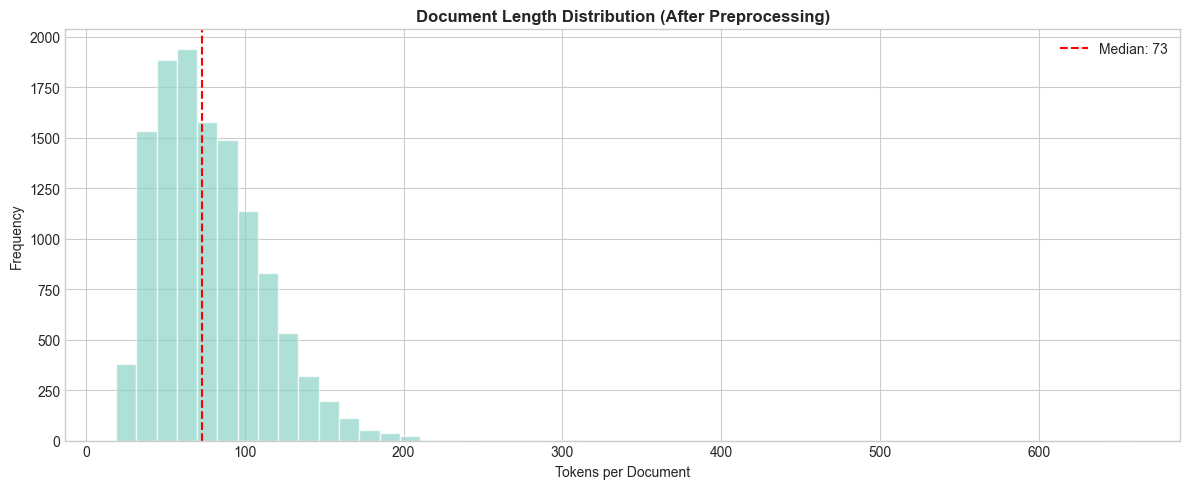

In [10]:
# Token length distribution
token_counts = [len(doc) for doc in processed_docs]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(token_counts, bins=50, edgecolor='white', alpha=0.7)
ax.axvline(np.median(token_counts), color='red', linestyle='--',
           label=f'Median: {np.median(token_counts):.0f}')
ax.set_xlabel('Tokens per Document')
ax.set_ylabel('Frequency')
ax.set_title('Document Length Distribution (After Preprocessing)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [11]:
# Top tokens after preprocessing
all_tokens = [token for doc in processed_docs for token in doc]
token_freq = Counter(all_tokens)

print(f"\nTop 50 tokens after preprocessing:")
print("-" * 50)
for token, count in token_freq.most_common(50):
    print(f"  {count:6d}: {token}")


Top 50 tokens after preprocessing:
--------------------------------------------------
   27719: perusahaan
    7365: keuangan
    6856: karyawan
    6207: kinerja
    4735: sistem
    3911: konsumen
    3835: produk
    3666: penjualan
    3331: kualitas
    3295: kota
    3288: positif
    3279: kinerja_karyawan
    3098: informasi
    3077: pajak
    2986: pengujian
    2797: biaya
    2613: kerja
    2504: manajemen
    2444: responden
    2313: bank
    2312: produksi
    2293: pegawai
    2286: akuntansi
    2246: jasa
    2222: keputusan_pembelian
    2046: audit_internal
    1972: pemerintah
    1959: harga_saham
    1935: pengendalian
    1912: sesuai
    1880: kualitas_pelayanan
    1877: sistem_informasi
    1859: profitabilitas
    1846: usaha
    1846: pengendalian_internal
    1768: audit
    1759: orang
    1758: independen
    1750: internal
    1745: aktivitas
    1720: terdaftar_bursa
    1718: pelayanan
    1684: mempengaruhi
    1683: harga
    1674: aplikasi
    16

In [12]:
# Check for bigrams/trigrams
phrases = [t for t in token_freq if '_' in t]
print(f"\nDetected phrases (bigrams/trigrams): {len(phrases)}")

if phrases:
    print("\nTop 20 phrases:")
    phrase_counts = {p: token_freq[p] for p in phrases}
    for phrase, count in sorted(phrase_counts.items(), key=lambda x: -x[1])[:20]:
        print(f"  {count:5d}: {phrase}")


Detected phrases (bigrams/trigrams): 2019

Top 20 phrases:
   3279: kinerja_karyawan
   2222: keputusan_pembelian
   2046: audit_internal
   1959: harga_saham
   1880: kualitas_pelayanan
   1877: sistem_informasi
   1846: pengendalian_internal
   1720: terdaftar_bursa
   1641: sumber_daya
   1528: disiplin_kerja
   1483: wajib_pajak
   1383: motivasi_kerja
   1250: gaya_kepemimpinan
   1247: kepatuhan_wajib
   1227: regresi_linear
   1153: bursa_efek
   1095: kualitas_produk
   1072: regresi_linier
   1025: penerimaan_pajak
   1023: sisa_dipengaruhi


## 5. Create DataFrame with Tokens

In [13]:
# Filter original dataframe to match processed documents
# (some documents may have been skipped due to short length)

# Find valid indices
valid_indices = []
doc_idx = 0

for i, abstract in enumerate(abstracts):
    tokens = preprocessor.preprocess_text(abstract, apply_phrases=False)
    if len(tokens) >= settings.min_doc_length:
        valid_indices.append(i)

# Create result dataframe
df_processed = df.iloc[valid_indices].copy().reset_index(drop=True)
df_processed['tokens'] = processed_docs
df_processed['token_count'] = [len(doc) for doc in processed_docs]

print(f"Processed dataframe: {len(df_processed):,} records")

Processed dataframe: 12,055 records


In [14]:
# Preview
df_processed[['title', 'token_count', 'tokens']].head()

,title,token_count,tokens
0,PENGARUH BUDAYA KESELAMATAN DAN KESEHATAN KERJ...,83,"[budaya, keselamatan_kesehatan, kerja, produkt..."
1,Pengaruh Kompensasi terhadap Motivasi Kerja Ka...,104,"[skripsi_disusun, andri, tanjung, nrp, judul, ..."
2,PERANAN SISTEM INFORMASI AKUNTANSI DALAM MENUN...,195,"[organisasi, didirikan, mencapai, mencari, lab..."
3,PENGARUH USIA DAN MASA KERJA TERHADAP PRODUKTI...,58,"[usia, kerja, produktivitas, pegawai, packer, ..."
4,PENGARUH SISTEM PENGENDALIAN INTERNAL PEMERINT...,52,"[sistem, pengendalian_internal, pemerintah, ku..."


## 6. Save Processed Data

In [15]:
# Save processed corpus
corpus_path = settings.processed_data_dir / settings.processed_corpus_file

corpus_data = {
    'documents': processed_docs,
    'dataframe': df_processed,
    'stats': preprocessor.stats,
}

with open(corpus_path, 'wb') as f:
    pickle.dump(corpus_data, f)

print(f"✅ Saved processed corpus to: {corpus_path}")

✅ Saved processed corpus to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_corpus.pkl


In [16]:
# Save preprocessor (for consistent preprocessing of new text)
preprocessor_path = settings.processed_data_dir / 'preprocessor.pkl'
preprocessor.save(preprocessor_path)
print(f"✅ Saved preprocessor to: {preprocessor_path}")

INFO:src.preprocessor:Saved preprocessor to C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\preprocessor.pkl


✅ Saved preprocessor to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\preprocessor.pkl


In [17]:
# Also save as CSV (without tokens for readability)
csv_path = settings.processed_data_dir / 'processed_metadata.csv'
df_processed.drop(columns=['tokens']).to_csv(csv_path, index=False)
print(f"✅ Saved metadata CSV to: {csv_path}")

✅ Saved metadata CSV to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_metadata.csv


## Summary

In [18]:
print("\n" + "=" * 60)
print("PREPROCESSING COMPLETE")
print("=" * 60)
print(f"\n📊 Documents processed: {len(processed_docs):,}")
print(f"📝 Unique tokens: {stats.unique_tokens:,}")
print(f"📈 Avg tokens/doc: {stats.avg_tokens_per_doc:.1f}")
print(f"⏱️  Total time: {stats.total_time_seconds:.1f}s")

print(f"\n📁 Output files:")
print(f"   - {corpus_path}")
print(f"   - {preprocessor_path}")
print(f"   - {csv_path}")

print(f"\n👉 Next: Run 04_lda_modeling.ipynb to train the LDA model")


PREPROCESSING COMPLETE

📊 Documents processed: 12,055
📝 Unique tokens: 35,814
📈 Avg tokens/doc: 77.8
⏱️  Total time: 54.8s

📁 Output files:
   - C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_corpus.pkl
   - C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\preprocessor.pkl
   - C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_metadata.csv

👉 Next: Run 04_lda_modeling.ipynb to train the LDA model
